# Overfit on a Small Dataset

## Imports

In [19]:
import numpy as np
import json
import copy
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from easydict import EasyDict
from sklearn.metrics import confusion_matrix
import os
import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

from dataset import BasketballDataset

## Arguments

In [20]:
args = EasyDict({

    'base_model_name': 'r2plus1d_multiclass',

    # training/model params
    'pretrained': True,
    'lr': 0.01,
    'start_epoch': 1,
    'num_epochs': 3,
    'layers_list': ['layer3', 'layer4', 'fc'],
    'continue_epoch': False,

    # Dataset params
    'num_classes': 10,
    'batch_size': 8,

    # Path params
    'annotation_path': "dataset/annotation_dict.json",
    'augmented_annotation_path': "dataset/augmented_annotation_dict.json",
    'model_path': "model/r2plus1d_overfit/",
    'history_path': "histories/history_r2plus1d_overfit.txt"
})

## Functions

### Metrics

In [21]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def get_acc_f1_precision_recall(pred_classes, ground_truths, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    """
    Given two linear arrays of predicted classes and ground truths, return accuracy, f1 score, precision and recall
    :param pred_classes: classes predicted by model
    :param ground_truths: ground truths for predictions
    :return: tuple of accuracy, f1, precision, recall
    """

    print(pred_classes)
    print(ground_truths)

    accuracy = np.mean((pred_classes == ground_truths)).astype(np.float64)
    f1 = f1_score(ground_truths, pred_classes, labels=labels, average='micro')
    precision = precision_score(ground_truths, pred_classes, labels=labels, average='micro')
    recall = recall_score(ground_truths, pred_classes, labels=labels, average='micro')

    return accuracy, f1, precision, recall

### Checkpoints

In [22]:
def init_session_history(args):
    """
    Initializes a section in the history file for current training session
    Creates file if it does not exist
    :param base_model_name: the model base name
    :return: None
    """

    with open(args.history_path, 'a+') as hist_fp:
        hist_fp.write(
            '\n============================== Base_model: {} ==============================\n'.format(args.base_model_name)

            + 'arguments: {}\n'.format(args)
        )

def save_weights(model, args, epoch, optimizer):
    """
    Saves a state dictionary given a model, epoch, the epoch its training in, and the optimizer
    :param base_model_name: name of the base model in training session
    :param model: model to save
    :param epoch: epoch model has trained to
    :param optimizer: optimizer used during training
    :param model_path: path of where model checkpoint is saved to
    :return:
    """

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    if not os.path.exists(args.model_path):
        os.mkdir(args.model_path)

    model_name = '{}_{}_{}'.format(args.base_model_name, epoch, args.lr)
    torch.save(state, '{}/{}.pt'.format(args.model_path, model_name))
    return model_name

def load_weights(model, args):
    """
    Loads previously trained weights into a model given an epoch and the model itself
    :param base_model_name: name of the base model in training session
    :param model: model to load weights into
    :param epoch: what epoch of training to load
    :param model_path: path of where model is loaded from
    :return: the model with weights loaded in
    """

    pretrained_dict = torch.load('{}/{}_{}_{}.pt'.format(args.model_path, args.base_model_name, args.start_epoch, args.lr))['state_dict']
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    return model


def plot_curves(base_model_name, train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, epochs):
    """
    Given progression of train/val loss/acc, plots curves
    :param base_model_name: name of base model in training session
    :param train_loss: the progression of training loss
    :param val_loss: the progression of validation loss
    :param train_acc: the progression of training accuracy
    :param val_acc: the progression of validation accuracy
    :param train_f1: the progression of training f1 score
    :param val_f1: the progression of validation f1 score
    :param epochs: epochs that model ran through
    :return: None
    """

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Loss curves')
    plt.legend()

    plt.subplot(132)
    plt.plot(epochs, train_acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Accuracy curves')
    plt.legend()

    plt.subplot(133)
    plt.plot(epochs, train_f1, label='train f1 score')
    plt.plot(epochs, val_f1, label='val f1 score')
    plt.xlabel('epochs')
    plt.ylabel('f1 score')
    plt.title('f1 curves')
    plt.legend()

    plt.suptitle(f'Session: {base_model_name}')

    #plt.savefig('previous_run.png')
    plt.show()

def write_history(
        history_path,
        model_name,
        train_loss,
        val_loss,
        train_acc,
        val_acc,
        train_f1,
        val_f1,
        train_precision,
        val_precision,
        train_recall,
        val_recall,
        train_confusion_matrix,
        val_confusion_matrix
):
    """
    Write a history.txt file for each model checkpoint
    :param history_path: path to history file
    :param model_name: name of the current model checkpoint
    :param train_loss: the training loss for current checkpoint
    :param val_loss: the validation loss for current checkpoint
    :param train_acc: the training accuracy for current checkpoint
    :param val_acc: the validation accuracy for current checkpoint
    :param train_f1: the training f1 score for current checkpoint
    :param val_f1: the validation f1 score for current checkpoint
    :param train_precision: the training precision score for current checkpoint
    :param val_precision: the validation precision score for current checkpoint
    :param train_recall: the training recall score for current checkpoint
    :param val_recall: the validation recall score for current checkpoint
    :param train_confusion_matrix: the training conf matrix for current checkpoint
    :param val_confusion_matrix: the validation conf matrix for current checkpoint
    :return: None
    """

    with open(history_path, 'a') as hist_fp:
        hist_fp.write(
            '\ncheckpoint name: {} \n'.format(model_name)

            + 'train loss: {} || train accuracy: {} || train f1: {} || train precision: {} || train recall: {}\n'.format(
                round(train_loss, 5),
                round(train_acc, 5),
                round(train_f1, 5),
                round(train_precision, 5),
                round(train_recall, 5)
            )

            + train_confusion_matrix + '\n'

            + 'val loss: {} || val accuracy: {} || val f1: {} || val precision: {} || val recall: {}\n'.format(
                round(val_loss, 5),
                round(val_acc, 5),
                round(val_f1, 5),
                round(val_precision, 5),
                round(val_recall, 5)
            )

            + val_confusion_matrix + '\n'
        )


def read_history(history_path):
    """
    Reads history file and prints out plots for each training session
    :param history_path: path to history file
    :return: None
    """

    with open(history_path, 'r') as hist:

        # get all lines
        all_lines = hist.readlines()

        # remove newlines for easier processing
        rem_newline = []
        for line in all_lines:
            if len(line) == 1 and line == '\n':
                continue
            rem_newline.append(line)

        # get individual training sessions
        base_names = []
        base_indices = []
        for i in range(len(rem_newline)):
            if rem_newline[i][0] == '=':
                base_names.append(rem_newline[i].replace('=', '').split(' ')[-2])
                base_indices.append(i)

        # create plots for each individual session
        for i in range(len(base_names)):
            name = base_names[i]

            # get last session
            if i == len(base_names) - 1:
                session_data = rem_newline[base_indices[i]:]

            # get session
            else:
                session_data = rem_newline[base_indices[i]: base_indices[i + 1]]

            # now generate the plots
            train_plot_loss = []
            val_plot_loss = []
            train_plot_acc = []
            val_plot_acc = []
            train_plot_f1 = []
            val_plot_f1 = []
            plot_epoch = []

            for line in session_data:

                if 'arguments' in line:
                    print("Hyperparameters:")
                    print(line)

                # case for getting checkpoint epoch
                if 'checkpoint' in line:
                    print(line)
                    plot_epoch.append(int(line.split('_')[-2]))

                # case for getting train data for epoch
                elif 'train' in line and 'arguments' not in line:
                    print(line)
                    train_plot_loss.append(float(line.split(' ')[2]))
                    train_plot_acc.append(float(line.split(' ')[6]))
                    train_plot_f1.append(float(line.split(' ')[10]))

                # case for getting val data for epoch
                elif 'val' in line:
                    print(line)
                    val_plot_loss.append(float(line.split(' ')[2]))
                    val_plot_acc.append(float(line.split(' ')[6]))
                    val_plot_f1.append(float(line.split(' ')[10]))

            # plot
            plot_curves(
                name,
                train_plot_loss,
                val_plot_loss,
                train_plot_acc,
                val_plot_acc,
                train_plot_f1,
                val_plot_f1,
                plot_epoch
            )


In [23]:
from torch import device


def train_model(model, base_model_name, dataloaders, criterion, optimizer, args, start_epoch=1, num_epochs=3):
    """
    Trains the 3D CNN Model
    :param model: Model object that we will train
    :param base_model_name: The base name of the model
    :param dataloaders: A dictionary of train and validation dataloader
    :param criterion: Pytorch Criterion Instance
    :param optimizer: Pytorch Optimizer Instance
    :param num_epochs: Number of epochs during training
    :return: model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch
    """

    # Initializes Session History in the history file
    init_session_history(args)
    since = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    train_f1_score = []
    val_f1_score = []
    plot_epoch = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                train_pred_classes = []
                train_ground_truths = []
            else:
                model.eval()  # Set model to evaluate mode
                val_pred_classes = []
                val_ground_truths = []

            running_loss = 0.0
            running_corrects = 0
            train_n_total = 1

            pbar = tqdm(dataloaders[phase])
            # Iterate over data.
            i = 0
            for sample in pbar:
                inputs = sample["video"]
                labels = sample["action"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    loss = criterion(outputs, torch.max(labels, 1)[1])

                    _, preds = torch.max(outputs, 1)
                    #print(preds)
                    #print(torch.max(labels, 1)[1])

                    if phase == 'train':
                        train_pred_classes.extend(preds.detach().cpu().numpy())
                        train_ground_truths.extend(torch.max(labels, 1)[1].detach().cpu().numpy())
                    else:
                        val_pred_classes.extend(preds.detach().cpu().numpy())
                        val_ground_truths.extend(torch.max(labels, 1)[1].detach().cpu().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

                pbar.set_description('Phase: {} || Epoch: {} || Loss {:.5f} '.format(phase, epoch, running_loss / train_n_total))
                train_n_total += 1
                i+=1
                if i==10:
                    break

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Calculate elapsed time
            time_elapsed = time.time() - since
            print(phase, ' training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # For Checkpointing and Confusion Matrix
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_pred_classes = np.asarray(val_pred_classes)
                val_ground_truths = np.asarray(val_ground_truths)
                val_accuracy, val_f1, val_precision, val_recall = get_acc_f1_precision_recall(
                    val_pred_classes, val_ground_truths
                )
                val_f1_score.append(val_f1)
                val_confusion_matrix = np.array_str(confusion_matrix(val_ground_truths, val_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
                print('Epoch: {} || Val_Acc: {} || Val_Loss: {}'.format(
                    epoch, val_accuracy, epoch_loss
                ))
                print(f'val: \n{val_confusion_matrix}')

                # Deep Copy Model if best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # set current loss to val loss for write history
                val_loss = epoch_loss

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_pred_classes = np.asarray(train_pred_classes)
                train_ground_truths = np.asarray(train_ground_truths)
                train_accuracy, train_f1, train_precision, train_recall = get_acc_f1_precision_recall(
                    train_pred_classes, train_ground_truths
                )
                train_f1_score.append(train_f1)
                train_confusion_matrix = np.array_str(confusion_matrix(train_ground_truths, train_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
                print('Epoch: {} || Train_Acc: {} || Train_Loss: {}'.format(
                    epoch, train_accuracy, epoch_loss
                ))
                print(f'train: \n{train_confusion_matrix}')
                plot_epoch.append(epoch)

                # set current loss to train loss for write history
                train_loss = epoch_loss

        # Save Weights
        model_name = save_weights(model, args, epoch, optimizer)

        # Write History after train and validation phase
        write_history(
            args.history_path,
            model_name,
            train_loss,
            val_loss,
            train_accuracy,
            val_accuracy,
            train_f1,
            val_f1,
            train_precision,
            val_precision,
            train_recall,
            val_recall,
            train_confusion_matrix,
            val_confusion_matrix
        )

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch

In [24]:
with open("dataset/annotation_dict.json") as f:
    annotation_dict = list(json.load(f).items())

In [25]:
# Defence - "block"
stop = [val for val in annotation_dict if val[1] == 0]
# Passing
ball_pass = [val for val in annotation_dict if val[1] == 1]
# Race or Running
race = [val for val in annotation_dict if val[1] == 2]
# Dribble
pallegio = [val for val in annotation_dict if val[1] == 3]
# Shooting
shooting = [val for val in annotation_dict if val[1] == 4]
# Ball In Hand
ballinhand = [val for val in annotation_dict if val[1] == 5]
# Defensive Position
defence = [val for val in annotation_dict if val[1] == 6]
# Pick Attempt
pick_attempt = [val for val in annotation_dict if val[1] == 7]
# No Action - Just standing
noaction = [val for val in annotation_dict if val[1] == 8]
# walk
walk = [val for val in annotation_dict if val[1] == 9]

In [26]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
# print("Current Device: ", torch.cuda.current_device())
# print("Device: ", torch.cuda.device(0))
# print("Cuda Is Available: ", torch.cuda.is_available())
# print("Device Count: ", torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.0.0
Torchvision Version:  0.15.1


In [27]:
#Load Dataset
basketball_dataset = BasketballDataset(annotation_dict=args.annotation_path,
                                       augmented_dict=args.augmented_annotation_path)

In [28]:
basketball_dataset[99]['action']

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64)

In [29]:
basketball_dataset[20]['class']

2

In [30]:
# for i in range(0, 1000):
#     if basketball_dataset[i]['class'] == 9:
#         print(basketball_dataset[i]['action'])

In [31]:
train_dataset_size = len(basketball_dataset)
train_dataset_indices = list(range(train_dataset_size))
np.random.shuffle(train_dataset_indices)
train_idx = train_dataset_indices[:100]
test_idx = train_dataset_indices[100:200]

In [32]:
train_subset = Subset(basketball_dataset, train_idx)
test_subset = Subset(basketball_dataset, test_idx)

In [33]:
# for i in range(0, 50):
#     print(train_subset[i]["action"])

In [34]:
train_loader = DataLoader(dataset=train_subset, shuffle=False, batch_size=10)
val_loader = DataLoader(dataset=test_subset, shuffle=False, batch_size=10)
dataloaders_dict = {'train': train_loader, 'val': val_loader}

In [35]:
# Initialize R(2+1)D Model
model = models.video.r2plus1d_18(pretrained=args.pretrained, progress=True)

# change final fully-connected layer to output 10 classes
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    for layer in args.layers_list:
        if layer in name:
            param.requires_grad = True

# input of the next hidden layer
num_ftrs = model.fc.in_features
# New Model is trained with 128x176 images
# Calculation:
model.fc = nn.Linear(num_ftrs, args.num_classes, bias=True)
print(model)

params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

/Users/zharec/basketball-action-recognition-1/space-jam-fork/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zharec/basketball-action-recognition-1/space-jam-fork/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [36]:
dataloaders_dict
pbar = tqdm(dataloaders_dict['val'])
# Iterate over data.
i = 0
for x in pbar:
    i += 1
    if i == 1:
        break
    print(x)
    break
    

  0%|          | 0/10 [00:00<?, ?it/s]OpenCV: Couldn't read video stream from file "dataset/videos/0005861_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0026500_flipped_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0004482_flipped_translate_32_0.mp4"
  0%|          | 0/10 [00:00<?, ?it/s]


In [37]:
# Train
optimizer_ft = optim.Adam(params_to_update, lr=args.lr)

criterion = nn.CrossEntropyLoss()

if args.continue_epoch:
    model = load_weights(model, args)
    model = model.to(device)
    criterion = criterion.to(device)

# Train and evaluate
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch = train_model(model,
                                                                                                                                        args.base_model_name,
                                                                                                                                        dataloaders_dict,
                                                                                                                                        criterion,
                                                                                                                                        optimizer_ft,
                                                                                                                                        args,
                                                                                                                                        start_epoch=args.start_epoch,
                                                                                                                                        num_epochs=args.num_epochs)

print("Best Validation Loss: ", min(val_loss_history), "Epoch: ", val_loss_history.index(min(val_loss_history)))
print("Best Training Loss: ", min(train_loss_history), "Epoch: ", train_loss_history.index(min(train_loss_history)))

  0%|          | 0/10 [00:00<?, ?it/s]OpenCV: Couldn't read video stream from file "dataset/videos/0001291_flipped_rotate_330.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0033907_rotate_30.mp4"
Phase: train || Epoch: 1 || Loss 24.00603 :  10%|█         | 1/10 [00:13<02:04, 13.85s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0023572_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0000721_rotate_30.mp4"
Phase: train || Epoch: 1 || Loss 41.08562 :  20%|██        | 2/10 [00:27<01:48, 13.59s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0012166_rotate_330.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0037142_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0023322_translate_-32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0031843_flipped_rotate_30.mp4"
Phase: train || Epoch: 1 || Loss 37.18781 :  30%|███       |

train  training complete in 2m 2s
train Loss: 3.6320 Acc: 0.1100
[1 1 1 2 1 1 1 1 1 1 9 9 3 8 8 9 9 9 9 8 8 9 9 9 9 8 9 9 9 9 9 0 0 0 0 0 9
 0 0 0 0 0 9 0 0 0 0 9 0 0 2 2 0 0 4 4 0 2 0 0 2 2 2 2 4 4 2 2 2 2 4 2 2 4
 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2]
[9 8 0 9 3 9 8 9 6 1 9 6 0 2 1 2 9 5 4 9 9 2 9 1 0 0 4 8 9 5 8 2 3 0 0 8 2
 9 8 9 6 8 4 2 2 0 2 0 1 4 9 2 8 4 6 0 7 5 7 9 2 7 1 9 7 3 3 9 8 2 2 9 3 8
 3 4 9 6 9 9 0 6 3 7 9 3 3 1 6 9 8 8 8 1 5 9 7 5 7 3]
Epoch: 1 || Train_Acc: 0.11 || Train_Loss: 3.632034707069397
train: 
[[ 3  1  1  1  1  0  0  0  1  2]
 [ 1  1  3  0  0  0  0  0  1  1]
 [ 4  0  3  0  1  0  0  0  1  3]
 [ 1  1  7  0  1  0  0  0  0  0]
 [ 2  0  1  0  0  0  0  0  0  3]
 [ 0  0  2  0  0  0  1  0  0  2]
 [ 1  1  3  0  1  0  0  0  0  1]
 [ 2  0  4  0  1  0  0  0  0  0]
 [ 4  2  4  0  1  0  0  0  0  2]
 [ 3  3 10  0  1  0  0  0  2  4]]


  0%|          | 0/10 [00:00<?, ?it/s]OpenCV: Couldn't read video stream from file "dataset/videos/0005861_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0026500_flipped_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0004482_flipped_translate_32_0.mp4"
Phase: val || Epoch: 1 || Loss 93219360.00000 :  10%|█         | 1/10 [00:11<01:40, 11.17s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0013944_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0001240_flipped_translate_-32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0032693_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0011251_flipped_translate_-32_0.mp4"
Phase: val || Epoch: 1 || Loss 98213335.00000 :  20%|██        | 2/10 [00:21<01:27, 10.97s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0014613_rotate_30.mp4"
OpenCV: Couldn't read video stream 

val  training complete in 3m 47s
val Loss: 8974661.8500 Acc: 0.0400
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[8 9 0 9 9 0 9 8 0 6 0 2 9 9 2 1 7 2 9 7 9 6 8 9 8 9 2 1 0 8 4 0 3 4 9 3 0
 9 0 9 3 2 8 9 6 1 2 5 9 9 9 5 2 3 7 9 9 9 5 9 1 8 9 7 4 8 1 7 1 6 3 9 2 2
 8 2 0 9 8 9 1 8 1 8 5 2 2 5 8 0 9 9 7 2 1 4 7 1 9 2]
Epoch: 1 || Val_Acc: 0.04 || Val_Loss: 8974661.85
val: 
[[ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0 28  0  0  0]]


  0%|          | 0/10 [00:00<?, ?it/s]OpenCV: Couldn't read video stream from file "dataset/videos/0001291_flipped_rotate_330.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0033907_rotate_30.mp4"
Phase: train || Epoch: 2 || Loss 35.67322 :  10%|█         | 1/10 [00:11<01:46, 11.81s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0023572_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0000721_rotate_30.mp4"
Phase: train || Epoch: 2 || Loss 34.75853 :  20%|██        | 2/10 [00:22<01:29, 11.19s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0012166_rotate_330.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0037142_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0023322_translate_-32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0031843_flipped_rotate_30.mp4"
Phase: train || Epoch: 2 || Loss 33.11979 :  30%|███       |

train  training complete in 5m 41s
train Loss: 2.8786 Acc: 0.1400
[2 2 2 6 2 2 2 2 2 2 8 8 2 2 8 2 6 8 2 3 2 3 3 3 3 8 3 3 3 3 3 3 3 8 3 3 3
 3 3 3 9 9 9 9 9 8 9 9 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[9 8 0 9 3 9 8 9 6 1 9 6 0 2 1 2 9 5 4 9 9 2 9 1 0 0 4 8 9 5 8 2 3 0 0 8 2
 9 8 9 6 8 4 2 2 0 2 0 1 4 9 2 8 4 6 0 7 5 7 9 2 7 1 9 7 3 3 9 8 2 2 9 3 8
 3 4 9 6 9 9 0 6 3 7 9 3 3 1 6 9 8 8 8 1 5 9 7 5 7 3]
Epoch: 2 || Train_Acc: 0.14 || Train_Loss: 2.878569722175598
train: 
[[ 0  0  2  2  0  0  0  0  3  3]
 [ 0  0  1  1  0  0  0  0  2  3]
 [ 0  0  2  3  0  0  0  0  0  7]
 [ 0  0  1  1  0  0  0  0  0  8]
 [ 0  0  1  1  0  0  0  0  0  4]
 [ 0  0  0  1  0  0  0  0  1  3]
 [ 0  0  1  0  0  0  0  0  1  5]
 [ 0  0  0  0  0  0  0  0  0  7]
 [ 0  0  2  4  0  0  0  0  0  7]
 [ 0  0  4  5  0  0  2  0  1 11]]


  0%|          | 0/10 [00:00<?, ?it/s]OpenCV: Couldn't read video stream from file "dataset/videos/0005861_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0026500_flipped_rotate_30.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0004482_flipped_translate_32_0.mp4"
Phase: val || Epoch: 2 || Loss 13603.47534 :  10%|█         | 1/10 [00:09<01:23,  9.24s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0013944_flipped_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0001240_flipped_translate_-32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0032693_translate_32_0.mp4"
OpenCV: Couldn't read video stream from file "dataset/videos/0011251_flipped_translate_-32_0.mp4"
Phase: val || Epoch: 2 || Loss 13771.02173 :  20%|██        | 2/10 [00:18<01:14,  9.30s/it]OpenCV: Couldn't read video stream from file "dataset/videos/0014613_rotate_30.mp4"
OpenCV: Couldn't read video stream from f

val  training complete in 7m 16s
val Loss: 1424.4396 Acc: 0.2800
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[8 9 0 9 9 0 9 8 0 6 0 2 9 9 2 1 7 2 9 7 9 6 8 9 8 9 2 1 0 8 4 0 3 4 9 3 0
 9 0 9 3 2 8 9 6 1 2 5 9 9 9 5 2 3 7 9 9 9 5 9 1 8 9 7 4 8 1 7 1 6 3 9 2 2
 8 2 0 9 8 9 1 8 1 8 5 2 2 5 8 0 9 9 7 2 1 4 7 1 9 2]
Epoch: 2 || Val_Acc: 0.28 || Val_Loss: 1424.439630126953
val: 
[[ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 14]
 [ 0  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0 13]
 [ 0  0  0  0  0  0  0  0  0 28]]
Training complete in 7m 18s
Best val Acc: 0.280000
Best Validation Loss:  1424.439630126953 Epoch:  1
Best Training Loss:  2.87856972

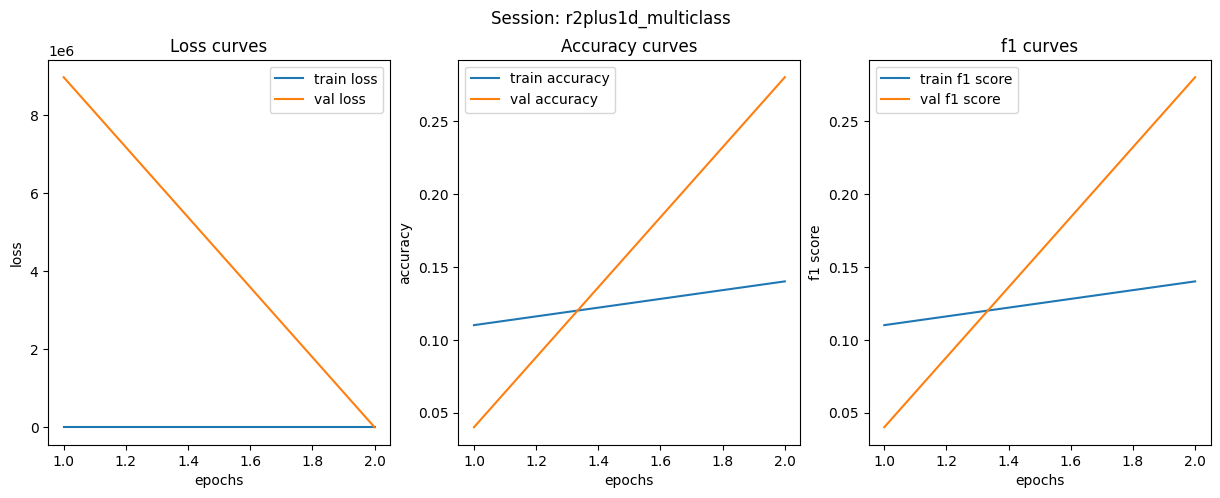

In [40]:
# Plot Final Curve
plot_curves(
    args.base_model_name,
    train_loss_history,
    val_loss_history,
    train_acc_history,
    val_acc_history,
    train_f1_score,
    val_f1_score,
    plot_epoch
)

Hyperparameters:
arguments: {'base_model_name': 'r2plus1d_multiclass', 'pretrained': True, 'lr': 0.01, 'start_epoch': 1, 'num_epochs': 3, 'layers_list': ['layer3', 'layer4', 'fc'], 'continue_epoch': False, 'num_classes': 10, 'batch_size': 8, 'annotation_path': 'dataset/annotation_dict.json', 'augmented_annotation_path': 'dataset/augmented_annotation_dict.json', 'model_path': 'model/r2plus1d_overfit/', 'history_path': 'histories/history_r2plus1d_overfit.txt'}



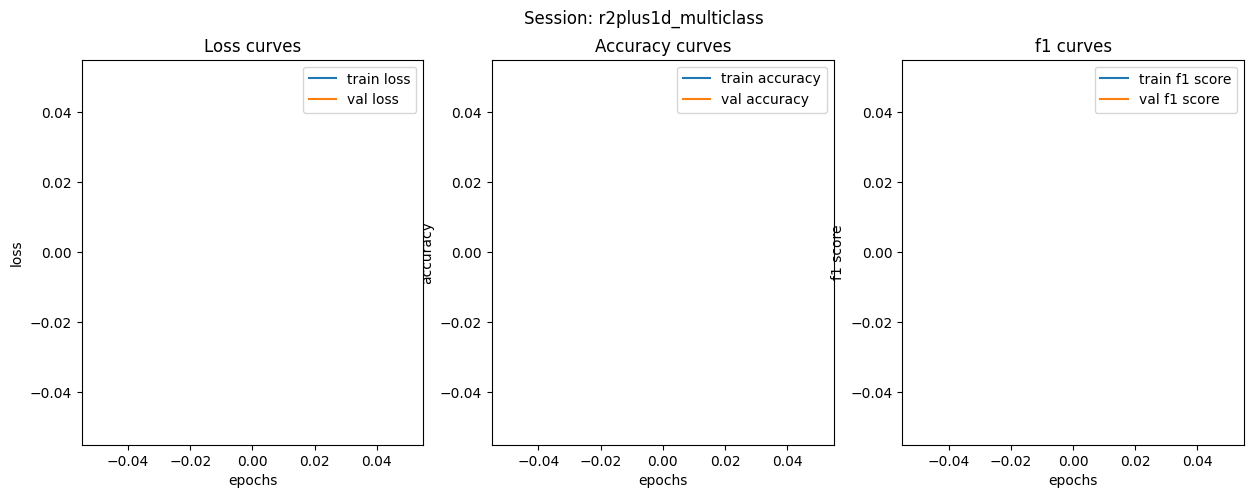

Hyperparameters:
arguments: {'base_model_name': 'r2plus1d_multiclass', 'pretrained': True, 'lr': 0.01, 'start_epoch': 1, 'num_epochs': 3, 'layers_list': ['layer3', 'layer4', 'fc'], 'continue_epoch': False, 'num_classes': 10, 'batch_size': 8, 'annotation_path': 'dataset/annotation_dict.json', 'augmented_annotation_path': 'dataset/augmented_annotation_dict.json', 'model_path': 'model/r2plus1d_overfit/', 'history_path': 'histories/history_r2plus1d_overfit.txt'}

checkpoint name: r2plus1d_multiclass_1_0.01 

train loss: 3.63203 || train accuracy: 0.11 || train f1: 0.11 || train precision: 0.11 || train recall: 0.11

val loss: 8974661.85 || val accuracy: 0.04 || val f1: 0.04 || val precision: 0.04 || val recall: 0.04

checkpoint name: r2plus1d_multiclass_2_0.01 

train loss: 2.87857 || train accuracy: 0.14 || train f1: 0.14 || train precision: 0.14 || train recall: 0.14

val loss: 1424.43963 || val accuracy: 0.28 || val f1: 0.28 || val precision: 0.28 || val recall: 0.28



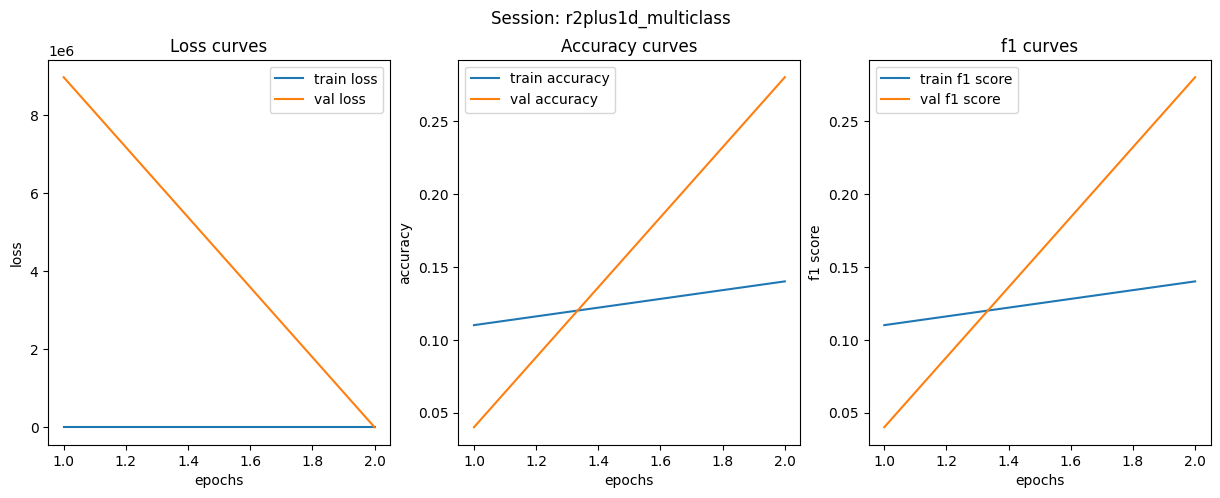

NameError: name 'check_accuracy' is not defined

In [39]:
# Read History
read_history(args.history_path)

# Check Accuracy with Test Set
check_accuracy(test_loader, model)